### 利用TFIDF方法針對不同類別文章取出百大關鍵字
1. 傳入excel檔案存成pd.dataframe
2. 找出有關「某主題」的文章，利用jieba切出所有2gram以上意義詞彙
3. 算出所有詞彙的tf df 值
4. 刪除tf < 文章數 * 1.5%, df < 文章數 * 1%的字詞
5. 計算tfidf值
6. 計算totaltd totaldf值
7. 計算MI,chi square
8. 計算adjusted tfidf = tfidf * MI * chi square

In [142]:
import pandas as pd
from nltk import ngrams
import monpa
import pickle

In [268]:
#dtypes = {"內容": "category"}
data = pd.read_csv('/Users/annerosey/Documents/大四/資料檢索語文字探勘/final_project/ptt_stock17.csv')
data2 = pd.read_csv('/Users/annerosey/Documents/大四/資料檢索語文字探勘/final_project/ptt_stock19.csv')

In [272]:
# 找到內容中含有“某主題”的資料，存成data
data = data.fillna(0)
data2 = data2.fillna(0)
stock2020 = pd.concat([data, data2], axis=0)
stock2020 = stock2020[stock2020.time.str.contains('2019')==False]
stock2020 = stock2020.drop_duplicates(keep='first', inplace=False)  # 刪除重複
stock2020

,author,title,time,content,url
0,louis960126 (JLingogo),Re: [標的] 鴻海 多,Thu Jan 14 22:48:05 2021,https://i.imgur.com/dGgzk3w.jpg\n去年四月的時候用博士獎學金...,https://www.ptt.cc/bbs/Stock/M.1610635687.A.5D...
1,Arizona989 (心平氣和，和氣生財),"[新聞] 氣候變遷題材發酵 美銀看好銅價突破10,000",Thu Jan 14 22:56:51 2021,\n1.原文連結：\n\nhttps://reurl.cc/3NDGEj\n\n2.原文內容...,https://www.ptt.cc/bbs/Stock/M.1610636213.A.1B...
2,CORYCHAN (CORY),[心得]台積電7nm & HPC Q4季減的解讀,Thu Jan 14 23:03:35 2021,台積電的Q4營收達到財測高標，表現亮眼。\n\n但身為同時持有台積電跟AMD的小戶，\n比較...,https://www.ptt.cc/bbs/Stock/M.1610636617.A.A3...
3,justicide (有話直說),Re: [標的] 美股 AMCX (AMC Networks) 不是AMC,Thu Jan 14 23:03:59 2021,從站上30元那天初次PO文至今，AMCX來到了4X元。想必大家也開始考慮是否該獲利了結。\n...,https://www.ptt.cc/bbs/Stock/M.1610636643.A.CB...
4,a025892000 (DK),[其他] 台積電ADR目前已大漲9%,Thu Jan 14 23:05:27 2021,\n乳題，今天法說會剛結束\n晚上ADR馬上漲給你看\n還一舉突破前高\n果然只要拉回就是最...,https://www.ptt.cc/bbs/Stock/M.1610636729.A.B6...
...,...,...,...,...,...
38302,luckystrike5 (霸王鮮果汁),Re: [請益] 交割戶重複交割,Mon Aug 17 22:26:04 2020,先告訴你結論\n很遺憾你拿不到什麼賠償\n台新最多手續費再給你一點點折扣\n下次記得打金管會...,https://www.ptt.cc/bbs/Stock/M.1597674366.A.C2...
38303,Jamire (^^),Re: [標的] 7566 亞果遊艇,Mon Aug 17 22:30:33 2020,董事捲入全台最大洗錢案 亞果遊艇發聲明澄清\n2020-08-17 15:39 經濟日報 /...,https://www.ptt.cc/bbs/Stock/M.1597674636.A.37...
38304,angellll (長尾巴的天使),Re: [新聞] 外資：聯發科5奈米晶片明年擬獲華為旗艦,Mon Aug 17 22:32:01 2020,※ 引述《charloette (三宅樹理)》之銘言：\n: https://news.cn...,https://www.ptt.cc/bbs/Stock/M.1597674724.A.A0...
38305,idome (你住海邊是不是?),[標的] 1799 易威 藥證多,Mon Aug 17 23:14:05 2020,\n1. 標的：1799 易威\n\n2. 分類：多\n\n3. 分析/正文：\n\n8/1...,https://www.ptt.cc/bbs/Stock/M.1597677248.A.45...


In [564]:
data2 = stock2020[stock2020.title.str.contains('標的')]
mask = (data2['content'].str.len() > 300)
data2 = data2.loc[mask]
data2 = data2.reset_index().drop('index',axis=1)

In [630]:
data2

,author,title,time,content,url
0,justicide (有話直說),Re: [標的] 美股 AMCX (AMC Networks) 不是AMC,Thu Jan 14 23:03:59 2021,從站上30元那天初次PO文至今，AMCX來到了4X元。想必大家也開始考慮是否該獲利了結。\n...,https://www.ptt.cc/bbs/Stock/M.1610636643.A.CB...
1,MiniArse (型男),Re: [標的]：美國石油公司 OXY.US,Thu Jan 14 23:28:28 2021,來到 24.x 囉...\n\n WTI 西德洲原油期貨已經差不多回到去年 1...,https://www.ptt.cc/bbs/Stock/M.1610638110.A.21...
2,poopooTaiwan (便便台灣),Re: [標的] 台積電 逃命空,Thu Jan 14 23:31:12 2021,相信今天有空的應該都有賺錢，\n但是現在ADR鬼神飆漲，\n明天空單還留著的快停力回補，\n...,https://www.ptt.cc/bbs/Stock/M.1610638278.A.16...
3,kksis (流浪人生),Re: [標的] 台積電 追高多,Thu Jan 14 23:38:57 2021,今日又進場買了100股總共600股，我知道上看1千感覺很可笑，但有夢最美希望相隨，買\n台積...,https://www.ptt.cc/bbs/Stock/M.1610638739.A.6F...
4,agqee (ptt),Re: [標的] 4976 佳凌 嘎空多,Thu Jan 14 23:44:28 2021,※ 引述《agqee (ptt)》之銘言：\n: 1. 標的：4976 佳凌\n: 2. 分...,https://www.ptt.cc/bbs/Stock/M.1610639070.A.44...
...,...,...,...,...,...
2440,amin82 (三省吾身),Re: [標的] 3406玉晶光，強力買進,Thu Jan 2 21:20:01 2020,回顧原po所說的，真的很準，短時間就上605元了，而且外資的目標價\n\n日系：668元\n...,https://www.ptt.cc/bbs/Stock/M.1577971203.A.01...
2441,a777starmy (呼力贏大師(大輸)),[標的] 2201裕隆，買進後會立即賺錢嗎?(立積),Thu Jan 2 14:11:52 2020,1. 標的：2201 裕隆\n2. 分類：多\n3. 分析/正文：\n\n籌碼愈來愈穩定，...,https://www.ptt.cc/bbs/Stock/M.1577945519.A.F7...
2442,Sunrisesky (伴讀書僮),[標的] 合晶 長多,Wed Jan 1 12:01:22 2020,1. 標的：6182合晶\n\n2. 分類：多/空/請益/心得\n長多\n\n3. 分析/正...,https://www.ptt.cc/bbs/Stock/M.1577851284.A.C8...
2443,Jamire (^^),Re: [標的] 7566 亞果遊艇,Mon Aug 17 22:30:33 2020,董事捲入全台最大洗錢案 亞果遊艇發聲明澄清\n2020-08-17 15:39 經濟日報 /...,https://www.ptt.cc/bbs/Stock/M.1597674636.A.37...


In [311]:
import csv
data2.to_csv(r'stock2020_Target2.csv',index = False)

In [312]:
# 刪掉標點符號及冗詞贅字，將所有乾淨的文章內容存成articles

def deleteWords(string):
    del_words = ["是","有","則","或","且","為","與","才","卻","但","就","還","並","先","的",'也',"了","後","而","的","嗎","吧"]
    for k in string:
        if(u'\u4e00' >= k or k >= u'\u9fff' or k in del_words):
            string = string.replace(k,"")
    return string


def ngram(content):
    seg = content.split("，")
    words = []
    for sentence in seg:
        sentence = deleteWords(sentence)
        word2 = monpa.cut(sentence)
        for word in word2:
            if(len(word) < 2):
                word2.remove(word)
        words.extend(word2)
    return words

In [313]:
SIZE= data2.shape[0]

data2['tokens']=data2['content'].apply(lambda x: ngram(str(x)))

In [314]:
data2

,author,title,time,content,url,tokens
0,justicide (有話直說),Re: [標的] 美股 AMCX (AMC Networks) 不是AMC,Thu Jan 14 23:03:59 2021,從站上30元那天初次PO文至今，AMCX來到了4X元。想必大家也開始考慮是否該獲利了結。\n...,https://www.ptt.cc/bbs/Stock/M.1610636643.A.CB...,"[站上, 那, 初次文, 至今, 來到, 元想必, 大家, 開始, 考慮, 該, 獲利, 以..."
1,MiniArse (型男),Re: [標的]：美國石油公司 OXY.US,Thu Jan 14 23:28:28 2021,來到 24.x 囉...\n\n WTI 西德洲原油期貨已經差不多回到去年 1...,https://www.ptt.cc/bbs/Stock/M.1610638110.A.21...,"[來到, 西德洲, 原油, 期貨, 已經, 差不多, 回到, 去年, 月底, 水準, 當時,..."
2,poopooTaiwan (便便台灣),Re: [標的] 台積電 逃命空,Thu Jan 14 23:31:12 2021,相信今天有空的應該都有賺錢，\n但是現在ADR鬼神飆漲，\n明天空單還留著的快停力回補，\n...,https://www.ptt.cc/bbs/Stock/M.1610638278.A.16...,"[相信, 今天, 應該, 賺錢, 現在, 鬼神, 飆漲, 明天, 空單, 著, 停力, 回補..."
3,kksis (流浪人生),Re: [標的] 台積電 追高多,Thu Jan 14 23:38:57 2021,今日又進場買了100股總共600股，我知道上看1千感覺很可笑，但有夢最美希望相隨，買\n台積...,https://www.ptt.cc/bbs/Stock/M.1610638739.A.6F...,"[今日, 進場, 股, 總共股, 知道, 看, 感覺, 可笑, 最, 希望, 相隨, 台, ..."
4,agqee (ptt),Re: [標的] 4976 佳凌 嘎空多,Thu Jan 14 23:44:28 2021,※ 引述《agqee (ptt)》之銘言：\n: 1. 標的：4976 佳凌\n: 2. 分...,https://www.ptt.cc/bbs/Stock/M.1610639070.A.44...,"[引述, 銘言標佳凌, 分類, 分析, 正文, 很多, 覺得, 值得, 個, 價位, 因此,..."
...,...,...,...,...,...,...
2440,amin82 (三省吾身),Re: [標的] 3406玉晶光，強力買進,Thu Jan 2 21:20:01 2020,回顧原po所說的，真的很準，短時間就上605元了，而且外資的目標價\n\n日系：668元\n...,https://www.ptt.cc/bbs/Stock/M.1577971203.A.01...,"[回顧, 所, 很, 時間, 元, 外資, 目標價, 日系, 美, 系元, 應該, 上調, ..."
2441,a777starmy (呼力贏大師(大輸)),[標的] 2201裕隆，買進後會立即賺錢嗎?(立積),Thu Jan 2 14:11:52 2020,1. 標的：2201 裕隆\n2. 分類：多\n3. 分析/正文：\n\n籌碼愈來愈穩定，...,https://www.ptt.cc/bbs/Stock/M.1577945519.A.F7...,"[標裕隆, 分類, 分析, 正文, 籌碼, 愈來愈, 穩定, 大家, 坐, 穩, 飛, 高高..."
2442,Sunrisesky (伴讀書僮),[標的] 合晶 長多,Wed Jan 1 12:01:22 2020,1. 標的：6182合晶\n\n2. 分類：多/空/請益/心得\n長多\n\n3. 分析/正...,https://www.ptt.cc/bbs/Stock/M.1577851284.A.C8...,"[標合晶, 分類, 多空請益心, 長多, 分析, 正文, 大家, 新年, 大家, 新年, 快..."
2443,Jamire (^^),Re: [標的] 7566 亞果遊艇,Mon Aug 17 22:30:33 2020,董事捲入全台最大洗錢案 亞果遊艇發聲明澄清\n2020-08-17 15:39 經濟日報 /...,https://www.ptt.cc/bbs/Stock/M.1597674636.A.37...,"[董事, 捲入, 台, 大, 洗錢案, 亞果, 遊艇, 發聲明, 澄清, 經濟日報, 記者,..."


In [315]:
import pickle
with open('stock_target_tokens.pickle','wb') as file:
    pickle.dump(data2, file) # 使用 dump 把 data 倒進去 file 裡面

In [316]:
data2 = pd.read_pickle("stock_target_tokens.pickle")

In [317]:
data2

,author,title,time,content,url,tokens
0,justicide (有話直說),Re: [標的] 美股 AMCX (AMC Networks) 不是AMC,Thu Jan 14 23:03:59 2021,從站上30元那天初次PO文至今，AMCX來到了4X元。想必大家也開始考慮是否該獲利了結。\n...,https://www.ptt.cc/bbs/Stock/M.1610636643.A.CB...,"[站上, 那, 初次文, 至今, 來到, 元想必, 大家, 開始, 考慮, 該, 獲利, 以..."
1,MiniArse (型男),Re: [標的]：美國石油公司 OXY.US,Thu Jan 14 23:28:28 2021,來到 24.x 囉...\n\n WTI 西德洲原油期貨已經差不多回到去年 1...,https://www.ptt.cc/bbs/Stock/M.1610638110.A.21...,"[來到, 西德洲, 原油, 期貨, 已經, 差不多, 回到, 去年, 月底, 水準, 當時,..."
2,poopooTaiwan (便便台灣),Re: [標的] 台積電 逃命空,Thu Jan 14 23:31:12 2021,相信今天有空的應該都有賺錢，\n但是現在ADR鬼神飆漲，\n明天空單還留著的快停力回補，\n...,https://www.ptt.cc/bbs/Stock/M.1610638278.A.16...,"[相信, 今天, 應該, 賺錢, 現在, 鬼神, 飆漲, 明天, 空單, 著, 停力, 回補..."
3,kksis (流浪人生),Re: [標的] 台積電 追高多,Thu Jan 14 23:38:57 2021,今日又進場買了100股總共600股，我知道上看1千感覺很可笑，但有夢最美希望相隨，買\n台積...,https://www.ptt.cc/bbs/Stock/M.1610638739.A.6F...,"[今日, 進場, 股, 總共股, 知道, 看, 感覺, 可笑, 最, 希望, 相隨, 台, ..."
4,agqee (ptt),Re: [標的] 4976 佳凌 嘎空多,Thu Jan 14 23:44:28 2021,※ 引述《agqee (ptt)》之銘言：\n: 1. 標的：4976 佳凌\n: 2. 分...,https://www.ptt.cc/bbs/Stock/M.1610639070.A.44...,"[引述, 銘言標佳凌, 分類, 分析, 正文, 很多, 覺得, 值得, 個, 價位, 因此,..."
...,...,...,...,...,...,...
2440,amin82 (三省吾身),Re: [標的] 3406玉晶光，強力買進,Thu Jan 2 21:20:01 2020,回顧原po所說的，真的很準，短時間就上605元了，而且外資的目標價\n\n日系：668元\n...,https://www.ptt.cc/bbs/Stock/M.1577971203.A.01...,"[回顧, 所, 很, 時間, 元, 外資, 目標價, 日系, 美, 系元, 應該, 上調, ..."
2441,a777starmy (呼力贏大師(大輸)),[標的] 2201裕隆，買進後會立即賺錢嗎?(立積),Thu Jan 2 14:11:52 2020,1. 標的：2201 裕隆\n2. 分類：多\n3. 分析/正文：\n\n籌碼愈來愈穩定，...,https://www.ptt.cc/bbs/Stock/M.1577945519.A.F7...,"[標裕隆, 分類, 分析, 正文, 籌碼, 愈來愈, 穩定, 大家, 坐, 穩, 飛, 高高..."
2442,Sunrisesky (伴讀書僮),[標的] 合晶 長多,Wed Jan 1 12:01:22 2020,1. 標的：6182合晶\n\n2. 分類：多/空/請益/心得\n長多\n\n3. 分析/正...,https://www.ptt.cc/bbs/Stock/M.1577851284.A.C8...,"[標合晶, 分類, 多空請益心, 長多, 分析, 正文, 大家, 新年, 大家, 新年, 快..."
2443,Jamire (^^),Re: [標的] 7566 亞果遊艇,Mon Aug 17 22:30:33 2020,董事捲入全台最大洗錢案 亞果遊艇發聲明澄清\n2020-08-17 15:39 經濟日報 /...,https://www.ptt.cc/bbs/Stock/M.1597674636.A.37...,"[董事, 捲入, 台, 大, 洗錢案, 亞果, 遊艇, 發聲明, 澄清, 經濟日報, 記者,..."


In [318]:
def count_tf(lst):
    tokens = {}
    for word in lst:
        if(len(word) >= 2):
            if word not in tokens:   
                tokens[word] = [1]
            else:
                tokens[word][0] += 1      
    return tokens

In [319]:
def count_df(df_dict,tokens):
    for w in tokens.keys():
        if w not in df_dict:
            df_dict.setdefault(w,[1,[]])  
            df_dict[w][1].append(i)      #posting
        else:
            df_dict[w][0] += 1  #df
            df_dict[w][1].append(i)      #posting
    return df_dict

In [320]:
"""
讀取所有文件:
1. 進行tokenize
2. 存取df到df_dict
3. 存取tf到tf_dict
"""
SIZE = data2.shape[0]
df_dict = {}  # record the word's total df
tf_dict = {}
for i in range(0,SIZE):
    t = data2.loc[i,'tokens']
    tf_dict[i] = count_tf(t)
    df_dict = count_df(df_dict,tf_dict[i])

In [321]:
"""
把df_dict存成dataframe並依照term由小到大排序
並且幫他們編號t_index
"""
df_df = pd.DataFrame(df_dict).T
df_df = df_df.sort_index()  #term按照字母大小排序
df_df = df_df.reset_index().reset_index()  #把term設為第二列,id設為第一列
df_df.columns = ["t_index","term","df","posting"]
df_df.t_index = df_df.t_index.apply(lambda x: x+1)
"""
Save as dictionary.txt
"""
with open('dictionary2.pickle','wb') as file:
    pickle.dump(df_df, file) # 使用 dump 把 data 倒進去 file 裡面
df_df.to_csv('dictionary2.txt', mode = 'w',sep='\t', index=False)

In [322]:
df_df

,t_index,term,df,posting
0,1,丁丁,2,"[795, 1260]"
1,2,丁二,1,[272]
2,3,丁二烯,1,[270]
3,4,七傷拳,1,[2166]
4,5,七八,7,"[706, 712, 849, 1374, 1961, 2239, 2324]"
...,...,...,...,...
31978,31979,龐大千,1,[1300]
31979,31980,龜密,3,"[89, 92, 119]"
31980,31981,龜山,1,[879]
31981,31982,龜毛,1,[329]


In [323]:
#計算tf-idf
def cal_tfidf(tf,df):
    return (tf * math.log10(SIZE/df))

In [324]:
for i in range(4):
    tf = pd.DataFrame(tf_dict[i]).T
    if(tf.shape[0]!=0):
        tf = tf.reset_index()
        tf.columns = ["term","tf"]

In [325]:
'''
紀錄Document 的tf-idf值：
1. 從tf_dict找到該文件的tf並存成dataframe
2. 將df_dict與tf_dict依照t_index合併與排序
3. 利用函數計算tf-idf值並存進docID.txt
'''
import math

for i in range(0,SIZE):
    tf = pd.DataFrame(tf_dict[i]).T
    if(tf.shape[0]!=0):
        tf = tf.reset_index()
        tf.columns = ["term","tf"]

        #將詞語的tf,df資料結合在一起
        tfidf = pd.merge(left= tf, right = df_df, how = "left", on = "term").drop("posting",axis=1)
        tfidf["tf-idf"] = 0  # 新增一欄位紀錄tf-idf 
        tfidf['tf-idf'] = tfidf.apply(lambda x: cal_tfidf(x.tf,x.df),axis = 1)
        deli = math.sqrt(tfidf["tf-idf"].apply(lambda x: x*x).sum())
        tfidf["tf-idf"] = tfidf["tf-idf"].apply(lambda x: x/deli)   #normalize tf-idf
        tfidf = tfidf.sort_values(by='t_index')   #將資料按照t_index文字編號進行排序
        
    tfidf.to_pickle("%s.pkl"%i)
    #存成 DocID.txt
    #with open('doc%s.txt'%i ,'w') as file:
        #file.write(str(tfidf.shape[0]) + "\n")

    #tfidf.to_csv('doc%s.txt'%i, mode = 'a',sep='\t', index=False)

In [631]:
tfidf

,term,tf,t_index,df,tf-idf
21,下跌,1,423,182,0.068113
60,主力,1,1059,268,0.057967
42,之前,1,1146,427,0.045754
22,今天,1,1622,929,0.025372
8,似乎,1,1829,116,0.079923
...,...,...,...,...,...
32,開始,1,29658,708,0.032495
58,階段,1,30238,79,0.089995
20,隨即,1,30266,14,0.135365
51,靠攏,1,30722,6,0.157581


In [326]:
import numpy as np
DICTSIZE = 31983
lst = np.arange(DICTSIZE)
lst

array([    0,     1,     2, ..., 31980, 31981, 31982])

In [327]:
df = pd.DataFrame(lst)
df.columns = ['t_index']
df.t_index = df.t_index.apply(lambda x: x+1)

In [328]:
df

,t_index
0,1
1,2
2,3
3,4
4,5
...,...
31978,31979
31979,31980
31980,31981
31981,31982


In [329]:
dfs = []
dfs.append(df)

In [330]:
dfs

[       t_index
 0            1
 1            2
 2            3
 3            4
 4            5
 ...        ...
 31978    31979
 31979    31980
 31980    31981
 31981    31982
 31982    31983
 
 [31983 rows x 1 columns]]

In [331]:
for i in range(0,SIZE):
    temp = pd.read_pickle("tfidf_for_target/%s.pkl"%i)
    temp2 = temp[['t_index','tf-idf']]
    temp2.columns = ['t_index',i]
    dfs.append(temp2)
    #pd.merge(left= df2 , right = temp2, how = "left", on = "t_index")
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [332]:
#把所有文章的vector建出來
from functools import reduce

df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['t_index'],how='outer'), dfs).fillna(0)
df_merged

,t_index,0,1,2,3,4,5,6,7,8,...,2435,2436,2437,2438,2439,2440,2441,2442,2443,2444
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31978,31979,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31979,31980,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31980,31981,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31981,31982,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [333]:
import pickle
with open('vectors.pickle','wb') as file:
    pickle.dump(df_merged, file) # 使用 dump 把 data 倒進去 file 裡面

In [334]:
a = pd.read_pickle("vectors.pickle")
vector = a.T

In [342]:
import pandas as pd
import math
#from pandas import pandas_profiling
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans

In [382]:
Error =[]
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i).fit(vector.iloc[1:,:31983])
    kmeans.fit(vector.iloc[1:,:31983])
    Error.append(kmeans.inertia_)
    print(i)

1
2
3
4
5
6
7
8
9
10


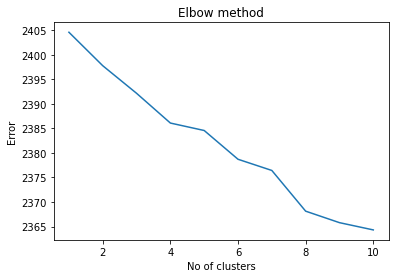

In [383]:
import matplotlib.pyplot as plt
plt.plot(range(1, 11), Error)
plt.title('Elbow method')
plt.xlabel('No of clusters')
plt.ylabel('Error')
plt.show()

In [522]:
# 如果分成30的話，每一群群的errors
error = pd.read_pickle("cluster_errors.pickle")
error

[2404.5863090674575,
 2397.7579532092614,
 2392.0026439262865,
 2387.529126113976,
 2383.978688999043,
 2379.680261757517,
 2376.777545486566,
 2373.262715294245,
 2369.297133700952,
 2365.5840921931813,
 2364.0920927702737,
 2351.226853205672,
 2358.9222769650632,
 2349.5690821088133,
 2347.7814792733475,
 2346.0913420289903,
 2341.9020965470268,
 2339.605733963969,
 2340.2536349053635,
 2336.5603133956647,
 2327.5851928748057,
 2331.2576531145837,
 2332.195849488114,
 2324.9174466702398,
 2323.4646333902624,
 2320.7242246008195,
 2317.5362554061635,
 2313.9972649368865,
 2315.0428322973735]

In [523]:
vector2 = vector.drop('t_index',axis = 0)

In [618]:
CLASS = 21
kmeans = KMeans(n_clusters=CLASS).fit(vector2.iloc[:,:31983])
vector2['K-means']= 0
vector2['K-means']= kmeans.fit_predict(vector2.iloc[:,:31983])
table = pd.DataFrame(kmeans.cluster_centers_)


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_fast._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt: 


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_fast._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
print(table)

In [633]:
vector2

,0,1,2,3,4,5,6,7,8,9,...,31974,31975,31976,31977,31978,31979,31980,31981,31982,K-means
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2440,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2441,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2442,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2443,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [605]:
with open('kmeans2_%s.pickle'%CLASS,'wb') as file:
    pickle.dump(vector2, file) # 使用 dump 把 data 倒進去 file 裡面

In [606]:
class_doc_cnt = []
for c in range(0,CLASS):
    class_doc_cnt.append(len(vector2[vector2['K-means'] == c]))

In [607]:
class_doc_cnt

[65,
 74,
 641,
 149,
 56,
 83,
 216,
 195,
 38,
 45,
 115,
 11,
 38,
 58,
 10,
 201,
 66,
 138,
 160,
 86]

### 把每一群的文章集中在class_dict裡面

In [608]:
class_dict = {}
for c in range(0,CLASS):
    class_dict[c]=list(vector2[vector2['K-means']== c].index)

In [609]:
with open('class_dict_%s.pickle'%CLASS,'wb') as file:
    pickle.dump(class_dict, file) # 使用 dump 把 data 倒進去 file 裡面

In [619]:
CLASS = 21
with open('class_dict_%s.pickle'%CLASS,'rb') as file:
    class_dict = pickle.load(file)

In [634]:
class_len = []
for c in range(0,CLASS):
    class_len.append(len(class_dict[c]))

In [635]:
class_len

[49,
 65,
 27,
 598,
 11,
 99,
 72,
 104,
 8,
 82,
 109,
 92,
 110,
 125,
 370,
 112,
 39,
 256,
 27,
 66,
 24]

## 找出每篇文章的feature words

In [620]:
def mergeDict(dict1, dict2):
    ''' Merge dictionaries and keep values of common keys in list'''
    dict3 = {}
    dict3.update(dict1)
    dict3.update(dict2)
    for key in dict3.keys():
        if key in dict1.keys() and key in dict2.keys():
            dict3[key][0] = dict2[key][0] + dict1[key][0]
    return dict3

In [621]:
class_tf_dict = {}
total_tf_dict = {}

for c in class_dict:  #對於每個分類
    class_tf_dict[c] = {}
    for i in class_dict[c]: #對於該分類裡面的每一篇文章
        class_tf_dict[c] = mergeDict(class_tf_dict[c],tf_dict[i])
    total_tf_dict = mergeDict(tf_dict[c],total_tf_dict) #計算每個字的總tf

In [622]:
# 計算每個分類的總字數
total_words_in_class = {}
for c in class_dict:  #對於每個分類
    total_words_in_class[c] = 0

# 計算所有字數
total_words = 0
for c in class_dict:  #對於每個分類
    for d in class_dict[c]:
        for i in tf_dict[d].values():
            total_words_in_class[c] += i[0]
    total_words += total_words_in_class[c]

In [623]:
chi = {}
TOTAL_DOC = 2445

for key in df_dict.keys():
    chi[key] = {}
    for c in range(0,CLASS):
        CLASS_DOC = len(class_dict[c])
        n11,n10,n01,n00 = 0,0,0,0
        for posting in df_dict[key][1]:
            if posting in class_dict[c]: # 如果這個字出現的文章當中，屬於這個class>n11,不屬於這個class>n01
                n11 +=1
            else:
                n01 +=1
        E = TOTAL_DOC*((n11+n01)/TOTAL_DOC)*(CLASS_DOC/TOTAL_DOC)
        chi[key][c] = ((n11-E)**2)/E   

In [624]:
chi_df = pd.DataFrame(chi)
chi_df = chi_df.T
chi_df

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
站上,0.533367,25.333828,1.126380,2.531687,0.638040,0.004096,0.000005,3.089782,0.333742,0.098047,...,3.838037,1.460615,60.658253,1.274613,0.022970,0.241624,2.050619,1.126380,1.116565,0.996325
初次文,0.020041,0.026585,0.011043,0.244581,0.004499,0.040491,0.029448,0.042536,0.003272,0.033538,...,0.037628,0.044990,0.051125,4.759437,0.045808,0.015951,0.104703,0.011043,0.026994,0.009816
至今,0.034087,18.314323,2.699614,2.194495,0.269939,2.429448,1.766871,0.078590,0.196319,2.012270,...,0.029408,0.033477,0.001485,0.000701,0.023020,17.078850,0.469709,8.245910,0.089329,0.588957
來到,3.126380,33.875050,6.234808,0.452389,0.701840,0.849587,0.553000,0.060879,0.510429,0.597521,...,2.551377,2.300748,12.600076,0.109441,5.285950,2.488344,9.822249,1.722699,2.448514,1.531288
元想必,0.020041,0.026585,0.011043,0.244581,0.004499,0.040491,0.029448,0.042536,0.003272,0.033538,...,0.037628,0.044990,0.051125,4.759437,0.045808,0.015951,0.104703,0.011043,0.026994,0.009816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
出血,0.020041,0.026585,0.011043,0.244581,0.004499,22.737460,0.029448,0.042536,0.003272,0.033538,...,0.037628,0.044990,0.051125,0.151329,0.045808,0.015951,0.104703,0.011043,0.026994,0.009816
核可,0.020041,0.026585,0.011043,0.244581,0.004499,22.737460,0.029448,0.042536,0.003272,0.033538,...,0.037628,0.044990,0.051125,0.151329,0.045808,0.015951,0.104703,0.011043,0.026994,0.009816
賭聲,0.020041,0.026585,0.011043,0.244581,0.004499,22.737460,0.029448,0.042536,0.003272,0.033538,...,0.037628,0.044990,0.051125,0.151329,0.045808,0.015951,0.104703,0.011043,0.026994,0.009816
利多連發,0.020041,0.026585,0.011043,0.244581,0.004499,22.737460,0.029448,0.042536,0.003272,0.033538,...,0.037628,0.044990,0.051125,0.151329,0.045808,0.015951,0.104703,0.011043,0.026994,0.009816


In [615]:
with open('chi_df_%s.pickle'%CLASS,'wb') as file:
    pickle.dump(chi_df, file) # 使用 dump 把 data 倒進去 file 裡面

In [628]:
class_voc_chi={}
for t in range(0,CLASS):
    class_voc_chi[t]= {}
    for i in chi_df[t].sort_values(ascending=False).head(100).index:
        class_voc_chi[t][i] = chi_df[t][i]

In [629]:
with open('feature_words_%s.txt'%CLASS, 'w') as out:
    for c in range(0,CLASS):
        for i in class_voc_chi[c]:
            out.write(i+',')
        out.write('\n = = = \n')